Install kaggle package for downloading the data

In [ ]:
!pip install kaggle

In [ ]:
# Upload the user credentials generated by Kaggle API 
from google.colab import files
files.upload()

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Getting the data

In [5]:
!kaggle datasets download -d sachinpatel21/az-handwritten-alphabets-in-csv-format

 93% 172M/185M [00:02<00:00, 67.6MB/s]
100% 185M/185M [00:02<00:00, 73.8MB/s]


Unzip the data

In [6]:

import zipfile
zip_ref = zipfile.ZipFile('az-handwritten-alphabets-in-csv-format.zip', 'r')
zip_ref.extractall('sample_data')
zip_ref.close()


Prepare the data

It come from 2 datasets :
 * MNIST DATASET
 * A-Z CHARACTERS DATASET

Both dataset consist in 28x28 images, representing alpha-numerical characters

In [9]:
import numpy as np

def load_az_dataset(datasetPath):
  data = []
  labels = []
  for line in open(datasetPath):
      line = line.split(",")
      label = int(line[0])
      image = np.array([int(x) for x in line[1:]], dtype="uint8")
      image = image.reshape((28, 28))
      data.append(image)
      labels.append(label)

  data = np.array(data, dtype = "float32")
  labels = np.array(labels, dtype = "float32")
  return (data, labels)



In [10]:
from tensorflow.keras.datasets import mnist

def load_09_set():
  (trainX, trainY), (testX, testY) = mnist.load_data()
  data = np.vstack([trainX, testX])
  labels = np.hstack([trainY, testY])
  return (data, labels)

Creating the CNN Arhitecture

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

In [12]:
inputs = Input(shape = (28, 28, 1))


conv1  = Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'relu')(inputs)
maxp1  = MaxPool2D(pool_size = (2,2))(conv1)
bat1   = BatchNormalization()(maxp1)
x = Dropout(0.3)(bat1)

conv2  = Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'relu')(x)
maxp2  = MaxPool2D(pool_size = (2,2))(conv2)
bat2   = BatchNormalization()(maxp2)
x = Dropout(0.5)(bat2)

conv3  = Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation = 'relu')(x)
maxp2  = MaxPool2D(pool_size = (2,2))(conv3)
bat2   = BatchNormalization()(maxp2)

flat = Flatten()(bat2)
dense = Dense(256, activation = 'relu')(flat)
x = Dropout(0.5)(dense)
outputs = Dense(36, activation = 'softmax')(x)

model = Model(inputs = inputs, outputs = outputs, name = "OCRModel")




In [13]:
model.summary()

Model: "OCRModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0  

Loading the images and labels

In [14]:
(azData, azLabels) = load_az_dataset("sample_data/A_Z Handwritten Data.csv")
(digitsData, digitsLabels) = load_09_set()

11493376/11490434 [==============================] - 0s 0us/step


Visualize the data

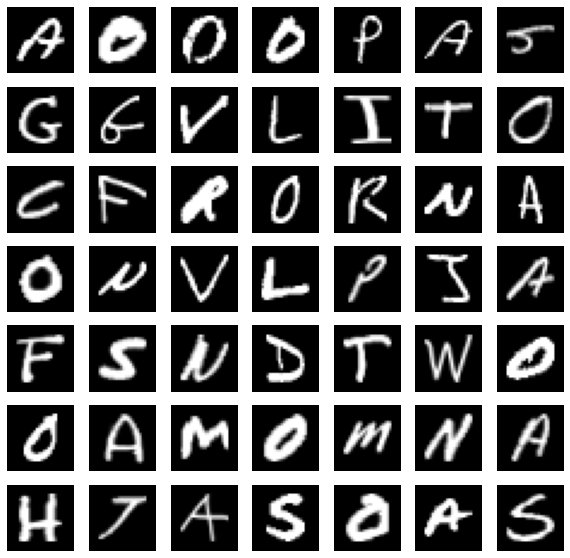

In [53]:
import matplotlib.pyplot as plt
import random 
plt.figure(figsize=(10, 10))

for i in range(49):
  idx = random.randint(0, len(azData))
  image = azData[idx]
  ax = plt.subplot(7, 7, i + 1)
  plt.imshow(image, cmap='gray')
  plt.axis("off")

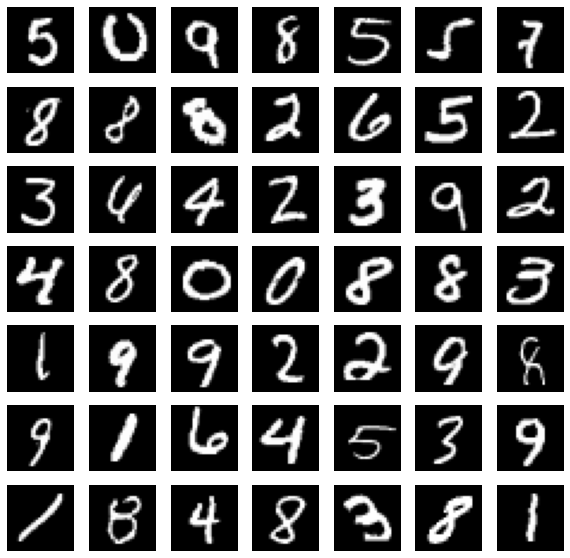

In [54]:
import matplotlib.pyplot as plt
import random 
plt.figure(figsize=(10, 10))

for i in range(49):
  idx = random.randint(0, len(digitsData))
  image = digitsData[idx]
  ax = plt.subplot(7, 7, i + 1)
  plt.imshow(image, cmap='gray')
  plt.axis("off")

Digits have labels from 0-9 and alphabet letters have labels from 0-25, we need to modify them to be in 10-35 range, so we add 10.

In [25]:
azLabels += 10

Concatenate the data

In [26]:
data = np.vstack([azData, digitsData])
labels = np.hstack([azLabels, digitsLabels])

data = np.array(data, dtype='float32')


Reshaping the data and normalize it

In [27]:
data = np.expand_dims(data, axis= -1)
data /= 255.0 

Binarize labels in a one-vs-all fashion.

In [28]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
labels = lb.fit_transform(labels)


Data Augmentation - a technique used to increase the amount of data by adding slightly modified copies of already existing data or newly created synthetic data from existing data


In [51]:
augmentations = ImageDataGenerator(
    rotation_range = 10,
    zoom_range = 0.15,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = "False",
    vertical_flip = "False",
    fill_mode = "nearest"
)

Visualize some augmented images

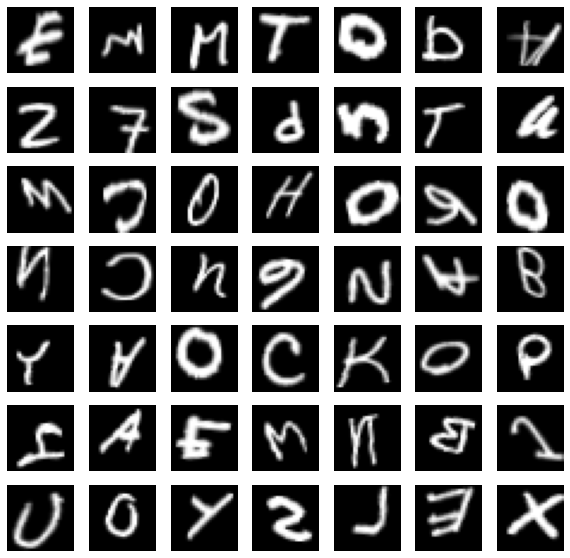

In [52]:

plt.figure(figsize=(10, 10))

for i in range(49):
  idx = random.randint(0, len(data))
  image = data[idx]
  image = np.expand_dims(image, axis = 0)
  ax = plt.subplot(7, 7, i + 1)
  imageGen = augmentations.flow(image, batch_size=1)
  batch = imageGen.next()
  plt.imshow(batch[0].squeeze(), cmap='gray')
  plt.axis("off")


Splitting the data

In [ ]:
from sklearn.model_selection import train_test_split
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size = 0.2, stratify = labels)

In [ ]:

EPOCHS = 50
LR = 1e-2
BATCH_SIZE = 128



In [ ]:
mycallbacks = [EarlyStopping(patience = 5, monitor = 'val_loss' )]

In [ ]:
model.compile(optimizer = 'rmsprop', loss ='categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
history = model.fit(augmentations.flow(trainX, trainY, batch_size = BATCH_SIZE),
                    validation_data = (testX, testY),
                    steps_per_epoch = len(trainX) // BATCH_SIZE,
                    epochs = EPOCHS,
                    callbacks = mycallbacks)

Epoch 1/50
2765/2765 [==============================] - 1066s 385ms/step - loss: 1.1393 - accuracy: 0.6776 - val_loss: 0.2485 - val_accuracy: 0.9255
Epoch 2/50
2765/2765 [==============================] - 1068s 386ms/step - loss: 0.4914 - accuracy: 0.8592 - val_loss: 0.2208 - val_accuracy: 0.9335
Epoch 3/50
2765/2765 [==============================] - 1068s 386ms/step - loss: 0.4383 - accuracy: 0.8729 - val_loss: 0.2082 - val_accuracy: 0.9365
Epoch 4/50
2765/2765 [==============================] - 1069s 387ms/step - loss: 0.3999 - accuracy: 0.8839 - val_loss: 0.2226 - val_accuracy: 0.9329
Epoch 5/50
2765/2765 [==============================] - 1076s 389ms/step - loss: 0.3683 - accuracy: 0.8920 - val_loss: 0.1981 - val_accuracy: 0.9419
Epoch 6/50
2765/2765 [==============================] - 1090s 394ms/step - loss: 0.3430 - accuracy: 0.8985 - val_loss: 0.1890 - val_accuracy: 0.9418
Epoch 7/50
2765/2765 [==============================] - 1088s 393ms/step - loss: 0.3331 - accuracy: 0.9017

In [ ]:
model.save("model.h5")

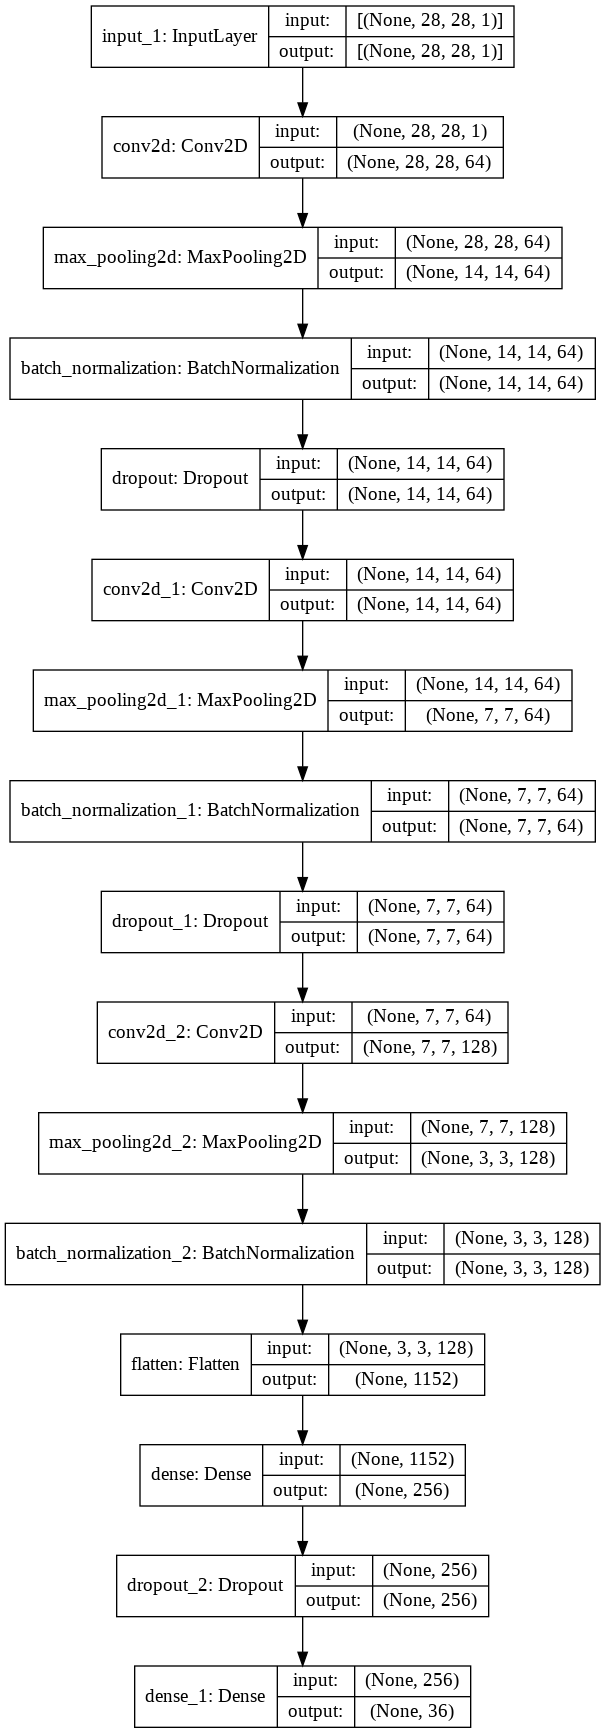

In [ ]:
tf.keras.utils.plot_model(model, to_file="ocrmodel.png", show_shapes=True, rankdir='TB',)

Evaluate the model on test data

In [ ]:
score = model.evaluate(testX, testY)

2766/2766 [==============================] - 63s 23ms/step - loss: 0.1939 - accuracy: 0.9408
